# Analisis de datos

In [125]:
import json
import pandas as pd
from collections import defaultdict
from scipy.stats import percentileofscore
import matplotlib.pyplot as plt

# Datos de entrenamiento y validación

In [126]:
# Mapeo de colores
color_map = ["white", "blue", "black", "red", "green"]

# Función para codificar los colores en una lista binaria
def encode_colors(colors):
    return ['1' if color in colors else '0' for color in color_map]


In [127]:
def get_tournaments_data(tournaments):
    data = []
    for tournament in tournaments:
        date = tournament["date"]
        positions = []
        color_stats = defaultdict(lambda: {"position_sum": 0, "popularity": 0, "positions": []})

        for position in tournament["positions"]:
            place = int(position["place"].replace("th", "").replace("st", "").replace("nd", "").replace("rd", ""))
            color_encoding = encode_colors(position["colors"])
            color_encoding_tuple = tuple(color_encoding)

            color_stats[color_encoding_tuple]["position_sum"] += place
            color_stats[color_encoding_tuple]["popularity"] += 1
            color_stats[color_encoding_tuple]["positions"].append(place)
            positions.append(place)  # Recolectar todas las posiciones para percentiles

        # Calcular el promedio de posiciones para cada combinación de colores
        for color_encoding, stats in color_stats.items():
            percentiles = [percentileofscore(positions, pos, kind='rank') for pos in stats["positions"]]
            average_position = stats["position_sum"] / stats["popularity"]
            average_percentile = sum(percentiles) / len(percentiles)  # Promedio de percentiles por combinación de colores
            
            data.append({
                "date": date,
                "color_encoding": ''.join(list(color_encoding)),
                "average_position": average_position,
                "average_percentile": average_percentile,
                "popularity": stats["popularity"]
            })

    # Convertir los datos a un DataFrame
    df = pd.DataFrame(data)
    df["date"] = pd.to_datetime(df["date"])

    # Agrupar por día y calcular el promedio diario del percentil
    daily_percentiles = df.groupby(["date", "color_encoding"]).agg({
        "average_percentile": "mean",
        "average_position": "mean",
        "popularity": "sum"
    }).reset_index()

    return daily_percentiles

In [128]:
# Cargar el archivo JSON
with open("pioneer_challenges.json") as f:
    tournaments = json.load(f)

df = get_tournaments_data(tournaments=tournaments)

In [129]:
def get_monthly_trend(dataframe):
    dataframe['date'] = pd.to_datetime(dataframe['date'])

    dataframe['month'] = dataframe['date'].dt.to_period('M')

    monthly_trend = dataframe.groupby(['month', 'color_encoding']).agg({
        'average_percentile': 'mean'
    }).reset_index()

    monthly_trend['month'] = monthly_trend['month'].dt.to_timestamp()
    return monthly_trend

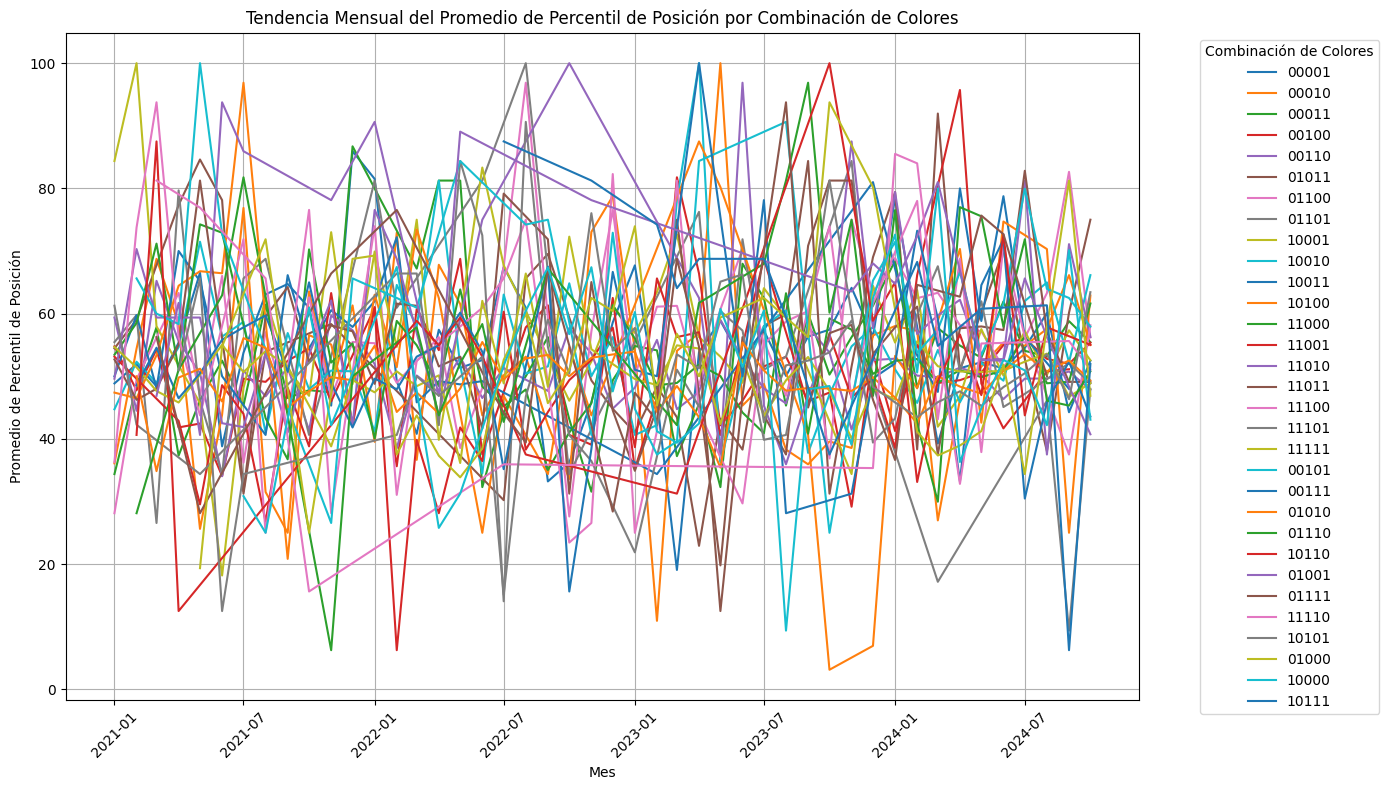

In [130]:
monthly_trend = get_monthly_trend(df)

plt.figure(figsize=(14, 8))
for color_combination in monthly_trend['color_encoding'].unique():
    subset = monthly_trend[monthly_trend['color_encoding'] == color_combination]
    plt.plot(subset['month'], subset['average_percentile'], label=str(color_combination))

plt.title('Tendencia Mensual del Promedio de Percentil de Posición por Combinación de Colores')
plt.xlabel('Mes')
plt.ylabel('Promedio de Percentil de Posición')
plt.legend(title="Combinación de Colores", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

In [131]:
unique_color_encodings = monthly_trend['color_encoding'].unique()
print(len(unique_color_encodings))
# for color_combination in unique_color_encodings:
#     subset = monthly_trend[monthly_trend['color_encoding'] == color_combination]
    
#     # Crear un nuevo gráfico
#     plt.figure(figsize=(10, 6))
#     plt.plot(subset['month'], subset['average_percentile'], marker='o', linestyle='-')
    
#     # Configuración del gráfico
#     plt.title(f'Tendencia Mensual para la Combinación de Colores {color_combination}')
#     plt.xlabel('Mes')
#     plt.ylabel('Promedio de Percentil de Posición')
#     plt.grid(True)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
    
#     # Mostrar el gráfico
#     plt.show()

31


In [132]:
df.head(10)

,date,color_encoding,average_percentile,average_position,popularity,month
0,2021-01-02,00001,29.687500,8.000000,2,2021-01
1,2021-01-02,00010,42.578125,6.125000,5,2021-01
2,2021-01-02,00011,62.500000,5.000000,2,2021-01
3,2021-01-02,00100,46.354167,11.833333,4,2021-01
4,2021-01-02,00110,100.000000,8.000000,1,2021-01
5,2021-01-02,01011,57.291667,18.333333,3,2021-01
6,2021-01-02,01101,64.062500,20.500000,4,2021-01
7,2021-01-02,10010,59.375000,8.500000,4,2021-01
8,2021-01-02,10100,59.375000,19.000000,5,2021-01
9,2021-01-02,11001,43.750000,14.000000,1,2021-01


In [133]:
df.tail(10)

,date,color_encoding,average_percentile,average_position,popularity,month
6561,2024-10-28,01100,12.500000,4.000000,2,2024-10
6562,2024-10-28,01110,40.625000,13.000000,2,2024-10
6563,2024-10-28,10000,100.000000,32.000000,2,2024-10
6564,2024-10-28,10001,60.156250,19.250000,8,2024-10
6565,2024-10-28,10100,12.500000,4.000000,2,2024-10
6566,2024-10-28,10110,57.812500,18.500000,4,2024-10
6567,2024-10-28,11000,41.666667,13.333333,6,2024-10
6568,2024-10-28,11011,59.375000,19.000000,2,2024-10
6569,2024-10-28,11101,49.218750,15.750000,8,2024-10
6570,2024-10-28,11111,47.656250,15.250000,6,2024-10


# Datos de pruebas

In [134]:
# Cargar el archivo JSON
with open("pioneer_challenges_test.json") as f:
    tournaments_test = json.load(f)

df_test = get_tournaments_data(tournaments=tournaments_test)



In [135]:
get_monthly_trend(df_test)
df_test.head()

,date,color_encoding,average_percentile,average_position,popularity,month
0,2024-10-31,00100,81.250000,26.000,1,2024-10
1,2024-10-31,00110,55.078125,17.625,8,2024-10
2,2024-10-31,01010,58.125000,18.600,10,2024-10
3,2024-10-31,01011,6.250000,2.000,1,2024-10
4,2024-10-31,01100,28.125000,9.000,1,2024-10


# Normalizacion y preparacion

In [136]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

## Agrupacion por mes

In [137]:
monthly_df = df.groupby(['month', 'color_encoding']).apply(
    lambda x: pd.Series({
        'average_percentile_monthly': np.sum(x['average_percentile'] * x['popularity']) / np.sum(x['popularity']),
        'average_popularity_monthly': np.mean(x['popularity'])
    })
).reset_index()

In [138]:
df_test.tail()

,date,color_encoding,average_percentile,average_position,popularity,month
193,2024-11-22,10100,15.625,5.0,1,2024-11
194,2024-11-22,10110,50.000,16.0,1,2024-11
195,2024-11-22,11000,6.250,2.0,1,2024-11
196,2024-11-22,11101,68.750,22.0,2,2024-11
197,2024-11-22,11111,31.250,10.0,3,2024-11


In [139]:
monthly_df_test = df_test.groupby(['month', 'color_encoding']).apply(
    lambda x: pd.Series({
        'average_percentile_monthly': np.sum(x['average_percentile'] * x['popularity']) / np.sum(x['popularity']),
        'average_popularity_monthly': np.mean(x['popularity'])
    })
).reset_index()

In [140]:
monthly_df_test.head()

,month,color_encoding,average_percentile_monthly,average_popularity_monthly
0,2024-10,00100,81.250000,1.0
1,2024-10,00110,55.078125,8.0
2,2024-10,01010,58.125000,10.0
3,2024-10,01011,6.250000,1.0
4,2024-10,01100,28.125000,1.0


In [141]:
monthly_df.head(10)

,month,color_encoding,average_percentile_monthly,average_popularity_monthly
0,2021-01,00001,47.694672,6.100000
1,2021-01,00010,32.756696,3.500000
2,2021-01,00011,43.750000,1.500000
3,2021-01,00100,40.487939,3.800000
4,2021-01,00110,59.375000,1.000000
5,2021-01,01011,54.939516,3.444444
6,2021-01,01100,38.541667,3.000000
7,2021-01,01101,56.180556,4.500000
8,2021-01,10001,84.375000,1.000000
9,2021-01,10010,53.188776,4.900000


## Rellenado de datos

In [142]:
all_months = monthly_df['month'].unique()
all_color_encodings = monthly_df['color_encoding'].unique()
all_combinations = pd.MultiIndex.from_product([all_months, all_color_encodings], names=['month', 'color_encoding']).to_frame(index=False)

all_combinations.head()

,month,color_encoding
0,2021-01,00001
1,2021-01,00010
2,2021-01,00011
3,2021-01,00100
4,2021-01,00110


In [143]:
monthly_df_complete = all_combinations.merge(monthly_df, on=['month', 'color_encoding'], how='left')
first_appearance = monthly_df_complete[monthly_df_complete['average_percentile_monthly'].notna()].groupby('color_encoding')['month'].min()

In [144]:
all_months_test = monthly_df_test['month'].unique()
all_color_encodings_test = monthly_df_test['color_encoding'].unique()
all_combinations_test = pd.MultiIndex.from_product([all_months_test, all_color_encodings_test], names=['month', 'color_encoding']).to_frame(index=False)

all_combinations_test.head()

,month,color_encoding
0,2024-10,00100
1,2024-10,00110
2,2024-10,01010
3,2024-10,01011
4,2024-10,01100


In [145]:
monthly_df_test_complete = all_combinations_test.merge(monthly_df_test, on=['month', 'color_encoding'], how='left')
first_appearance_test = monthly_df_test_complete[monthly_df_test_complete['average_percentile_monthly'].notna()].groupby('color_encoding')['month'].min()

In [146]:
def interpolate_from_first_appearance(df, column):
    for color_encoding, start_month in first_appearance.items():
        mask = (df['color_encoding'] == color_encoding) & (df['month'] >= start_month)
        df.loc[mask, column] = df.loc[mask, column].interpolate(method='linear', limit_direction='both')
    return df

In [147]:
monthly_df_complete = interpolate_from_first_appearance(monthly_df_complete, 'average_percentile_monthly')
monthly_df_complete['average_popularity_monthly'].fillna(0, inplace=True)

for color_encoding, start_month in first_appearance.items():
    mask = (monthly_df_complete['color_encoding'] == color_encoding) & (monthly_df_complete['month'] < start_month)
    monthly_df_complete.loc[mask, 'average_percentile_monthly'] = None

monthly_df_complete.dropna(subset=['average_percentile_monthly'], inplace=True)
monthly_df_complete.reset_index(drop=True, inplace=True)

In [148]:
monthly_df_test_complete = interpolate_from_first_appearance(monthly_df_test_complete, 'average_percentile_monthly')
monthly_df_test_complete['average_popularity_monthly'].fillna(0, inplace=True)

for color_encoding, start_month in first_appearance.items():
    mask = (monthly_df_test_complete['color_encoding'] == color_encoding) & (monthly_df_test_complete['month'] < start_month)
    monthly_df_test_complete.loc[mask, 'average_percentile_monthly'] = None

monthly_df_test_complete.dropna(subset=['average_percentile_monthly'], inplace=True)
monthly_df_test_complete.reset_index(drop=True, inplace=True)

In [149]:
monthly_df_complete.head()

,month,color_encoding,average_percentile_monthly,average_popularity_monthly
0,2021-01,00001,47.694672,6.1
1,2021-01,00010,32.756696,3.5
2,2021-01,00011,43.750000,1.5
3,2021-01,00100,40.487939,3.8
4,2021-01,00110,59.375000,1.0


In [150]:
monthly_df_test_complete.tail()

,month,color_encoding,average_percentile_monthly,average_popularity_monthly
47,2024-11,01111,93.750000,1.0
48,2024-11,10000,34.375000,1.0
49,2024-11,10010,44.270833,3.0
50,2024-11,10100,48.437500,1.6
51,2024-11,10101,90.625000,1.0


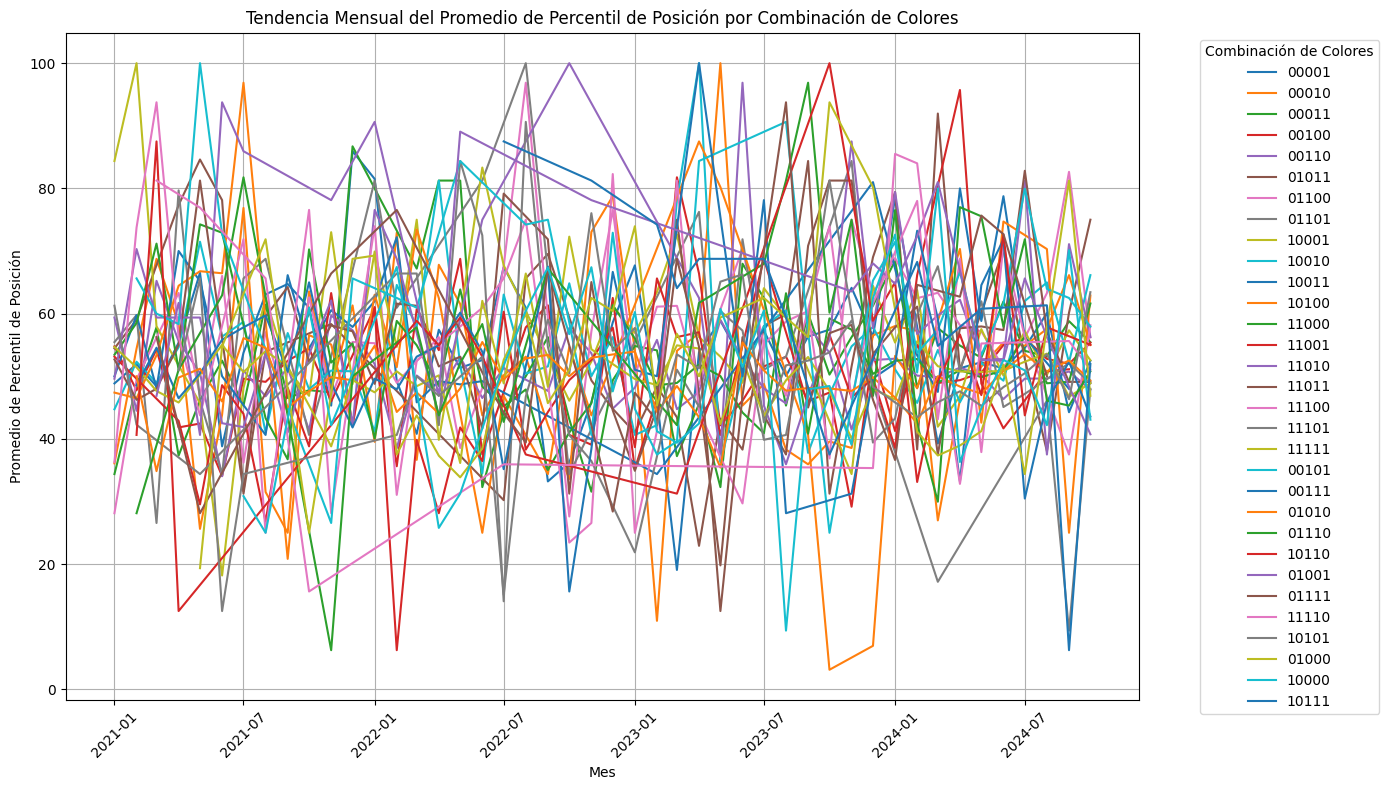

In [151]:
plt.figure(figsize=(14, 8))
for color_combination in monthly_df_complete['color_encoding'].unique():
    subset = monthly_trend[monthly_trend['color_encoding'] == color_combination]
    plt.plot(subset['month'], subset['average_percentile'], label=str(color_combination))

plt.title('Tendencia Mensual del Promedio de Percentil de Posición por Combinación de Colores')
plt.xlabel('Mes')
plt.ylabel('Promedio de Percentil de Posición')
plt.legend(title="Combinación de Colores", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

In [152]:
# for color_combination in unique_color_encodings:
#     subset = monthly_df_complete[monthly_df_complete['color_encoding'] == color_combination]
#     subset['month'] = subset['month'].dt.to_timestamp()
    
#     # Crear un nuevo gráfico
#     plt.figure(figsize=(10, 6))
#     plt.plot(subset['month'], subset['average_percentile_monthly'], marker='o', linestyle='-')
    
#     # Configuración del gráfico
#     plt.title(f'Tendencia Mensual para la Combinación de Colores {color_combination}')
#     plt.xlabel('Mes')
#     plt.ylabel('Promedio de Percentil de Posición')
#     plt.grid(True)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
    
#     # Mostrar el gráfico
#     plt.show()

## Normalizacion

In [153]:
scaler_percentile = MinMaxScaler()
monthly_df_complete['average_percentile_monthly_norm'] = scaler_percentile.fit_transform(monthly_df_complete[['average_percentile_monthly']])
monthly_df_complete['popularity_monthly_norm'] = np.log1p(monthly_df_complete['average_popularity_monthly'])
monthly_df_complete['color_encoding_norm'] = monthly_df_complete['color_encoding'].apply(lambda x: int(x, 2) / 31) 

In [154]:
monthly_df_complete.head()

,month,color_encoding,average_percentile_monthly,average_popularity_monthly,average_percentile_monthly_norm,popularity_monthly_norm,color_encoding_norm
0,2021-01,00001,47.694672,6.1,0.460074,1.960095,0.032258
1,2021-01,00010,32.756696,3.5,0.305876,1.504077,0.064516
2,2021-01,00011,43.750000,1.5,0.419355,0.916291,0.096774
3,2021-01,00100,40.487939,3.8,0.385682,1.568616,0.129032
4,2021-01,00110,59.375000,1.0,0.580645,0.693147,0.193548


In [155]:
monthly_df_test_complete['average_percentile_monthly_norm'] = scaler_percentile.fit_transform(monthly_df_test_complete[['average_percentile_monthly']])
monthly_df_test_complete['popularity_monthly_norm'] = np.log1p(monthly_df_test_complete['average_popularity_monthly'])
monthly_df_test_complete['color_encoding_norm'] = monthly_df_test_complete['color_encoding'].apply(lambda x: int(x, 2) / 31) 

In [156]:
monthly_df_test_complete.head()

,month,color_encoding,average_percentile_monthly,average_popularity_monthly,average_percentile_monthly_norm,popularity_monthly_norm,color_encoding_norm
0,2024-10,00100,81.250000,1.0,0.857143,0.693147,0.129032
1,2024-10,00110,55.078125,8.0,0.558036,2.197225,0.193548
2,2024-10,01010,58.125000,10.0,0.592857,2.397895,0.322581
3,2024-10,01011,6.250000,1.0,0.000000,0.693147,0.354839
4,2024-10,01100,28.125000,1.0,0.250000,0.693147,0.387097


## Preparacion de secuencias

In [157]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [158]:
monthly_df_complete['month_num'] = monthly_df_complete['month'].apply(lambda x: (x.year - monthly_df_complete['month'].min().year) * 12 + x.month)
monthly_df_test_complete['month_num'] = monthly_df_test_complete['month'].apply(lambda x: (x.year - monthly_df_test_complete['month'].min().year) * 12 + x.month)

In [159]:
cutoff_date = pd.Timestamp(year=pd.Timestamp.today().year, month=3, day=1)
train_data = monthly_df_complete[monthly_df_complete['month'].dt.to_timestamp() < cutoff_date]
val_data = monthly_df_complete[monthly_df_complete['month'].dt.to_timestamp() >= cutoff_date]

In [160]:
print(f"Train size: {train_data.shape[0]}, Val size: {val_data.shape[0]}, Split: {(val_data.shape[0]/train_data.shape[0])*100}%")

Train size: 1136, Val size: 248, Split: 21.830985915492956%


In [161]:
global_sequence_length = 1
global_features = ['color_encoding_norm', 'average_percentile_monthly_norm', 'popularity_monthly_norm']
target = 'average_percentile_monthly_norm'


In [162]:
full_train_gen = TimeseriesGenerator(
    train_data[global_features].values, train_data[target].values,
    length=global_sequence_length, batch_size=1
)

In [163]:
full_val_gen = TimeseriesGenerator(
    val_data[global_features].values, val_data[target].values,
    length=global_sequence_length, batch_size=1
)

In [164]:
print(monthly_df_test_complete.columns)

Index(['month', 'color_encoding', 'average_percentile_monthly',
       'average_popularity_monthly', 'average_percentile_monthly_norm',
       'popularity_monthly_norm', 'color_encoding_norm', 'month_num'],
      dtype='object')


In [165]:
monthly_df_test_complete.shape

(52, 8)

In [166]:
augmented_test_data = monthly_df_test_complete.reset_index(drop=True).copy()

new_row = pd.DataFrame(
    {
        'month':[0], 'color_encoding':[00000], 'average_percentile_monthly':[100],
       'average_popularity_monthly':[0], 'average_percentile_monthly_norm':[1],
       'popularity_monthly_norm':[0], 'color_encoding_norm':[0], 'month_num':[0]
    }
)

augmented_test_data_global = pd.concat([new_row,augmented_test_data]).reset_index(drop=True)


test_gen = TimeseriesGenerator(
    augmented_test_data_global[global_features].values, augmented_test_data_global[target].values,
    length=global_sequence_length, batch_size=1
)

In [167]:
train_timeseries_for_color = {}
val_timeseries_for_color = {}
specific_sequence_length = 6
specific_features = ['average_percentile_monthly_norm', 'popularity_monthly_norm']

for color_combination in monthly_df_complete['color_encoding'].unique():
    subset_train = train_data[train_data['color_encoding'] == color_combination]
    train_data_gen = TimeseriesGenerator(
        subset_train[specific_features].values, subset_train[target].values,
        length=specific_sequence_length, batch_size=1
    )
    train_timeseries_for_color[color_combination] = train_data_gen
    
    subset_val = val_data[val_data['color_encoding'] == color_combination]
    val_data_gen = TimeseriesGenerator(
        subset_val[specific_features].values, subset_val[target].values,
        length=specific_sequence_length, batch_size=1
    )
    val_timeseries_for_color[color_combination] = val_data_gen

In [168]:
test_timeseries_for_color = {}
specific_sequence_length = 6
specific_features = ['average_percentile_monthly_norm', 'popularity_monthly_norm']

initial_rows = pd.DataFrame(
        {
            "month": [0] * 6,
            "color_encoding": [color_combination] * 6,
            "average_percentile_monthly": [100] * 6,
            "average_popularity_monthly": [0] * 6,
            "average_percentile_monthly_norm": [1] * 6,
            "popularity_monthly_norm": [0] * 6,
            "color_encoding_norm": [0] * 6,
            "month_num": [0] * 6,
        }
    )

for color_combination in monthly_df_test_complete['color_encoding'].unique():
    subset_test = monthly_df_test_complete[monthly_df_test_complete['color_encoding'] == color_combination]
    
    augmented_test_data = pd.concat([initial_rows, subset_test]).reset_index(drop=True)

    test_data_gen = TimeseriesGenerator(
        augmented_test_data[specific_features].values, augmented_test_data[target].values,
        length=specific_sequence_length, batch_size=1
    )
    test_timeseries_for_color[color_combination] = test_data_gen
    

In [169]:
len(train_timeseries_for_color)

31

In [170]:
len(val_timeseries_for_color)

31

## Datos para Capa Densa

In [171]:
X_train = train_data[['month_num', 'color_encoding_norm', 'popularity_monthly_norm']].values
y_train = train_data['average_percentile_monthly_norm'].values

In [172]:
X_val = val_data[['month_num', 'color_encoding_norm', 'popularity_monthly_norm']].values
y_val = val_data['average_percentile_monthly_norm'].values


In [173]:
X_test = monthly_df_test_complete[['month_num', 'color_encoding_norm', 'popularity_monthly_norm']].values
y_test = monthly_df_test_complete['average_percentile_monthly_norm'].values

# Modelos

In [174]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,LSTM, Dense


## Modelo de Capa Densa -> Considera todos los datos

In [175]:
modelDense = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

modelDense.compile(optimizer='adam', loss='mse', metrics=['mae'])

## Modelo LSTM global -> toma en cuenta todas las combinaciones de colores

In [176]:
modelGlobalLSTM = Sequential([
    Input(shape=(global_sequence_length, len(global_features))),
    LSTM(50, activation='relu'),
    Dense(1)
])

modelGlobalLSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])

## Modelos LSTM Especificos -> Toman en cuenta unicamente el historial de una combinacion de colores

In [177]:
models_for_color = {}

epochs = 50
batch_size = 1

for color_combination, train_gen in train_timeseries_for_color.items():
    modelLSTM = Sequential([
        Input(shape=(specific_sequence_length, len(specific_features))),
        LSTM(50, activation='relu'),
        Dense(1)
    ])

    modelLSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    models_for_color[color_combination] = modelLSTM

# 1er Entrenamiento

## Modelo Denso

In [178]:
from tensorflow.keras.callbacks import EarlyStopping

In [179]:
history = modelDense.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    verbose=1
)

Epoch 1/50


71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1308 - mae: 0.2837 - val_loss: 0.0233 - val_mae: 0.1192
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 0.0426 - mae: 0.1606 - val_loss: 0.0789 - val_mae: 0.2522
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 0.0437 - mae: 0.1642 - val_loss: 0.0211 - val_mae: 0.1121
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 0.0298 - mae: 0.1310 - val_loss: 0.0184 - val_mae: 0.0956
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 0.0420 - mae: 0.1597 - val_loss: 0.0442 - val_mae: 0.1809
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 0.0379 - mae: 0.1491 - val_loss: 0.0209 - val_mae: 0.1132
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 0.0387 - mae: 0.1579 - val_loss: 0.0296 - val_mae: 0.1407
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 0.0343 - mae: 0.1436 - val_loss: 0.1427 - val_mae: 0.3565
Epoch 9/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 0.0420 - 

### Prueba

In [180]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [181]:
def show_test_results(y_pred, y_test):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Valores Reales', marker='o')
    plt.plot(y_pred, label='Predicciones', marker='x')
    plt.title('Comparación entre Valores Reales y Predicciones')
    plt.xlabel('Índice')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Mean Squared Error (MSE): 0.0502
Mean Absolute Error (MAE): 0.1689


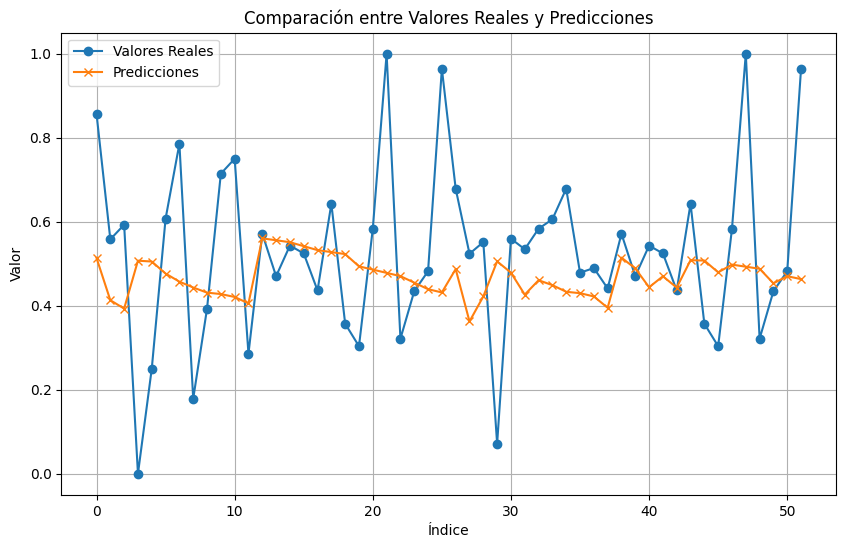

In [182]:
y_pred_dense = modelDense.predict(X_test)
show_test_results(y_pred_dense,y_test)

### Grafico

In [183]:
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
# plt.plot(history.history['val_loss'], label='Pérdida de validación')
# plt.xlabel('Épocas')
# plt.ylabel('Pérdida (MSE)')
# plt.title('Pérdida durante el entrenamiento')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['mae'], label='MAE de entrenamiento')
# plt.plot(history.history['val_mae'], label='MAE de validación')
# plt.xlabel('Épocas')
# plt.ylabel('MAE')
# plt.title('Error Absoluto Medio durante el entrenamiento')
# plt.legend()

# plt.tight_layout()
# plt.show()

## Modelo LSTM Global

In [184]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = modelGlobalLSTM.fit(
    full_train_gen,
    validation_data=full_val_gen,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1135/1135 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - loss: 0.0700 - mae: 0.2034 - val_loss: 0.0172 - val_mae: 0.0954
Epoch 2/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 0.0260 - mae: 0.1217 - val_loss: 0.0159 - val_mae: 0.0873
Epoch 3/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - loss: 0.0267 - mae: 0.1239 - val_loss: 0.0162 - val_mae: 0.0894
Epoch 4/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 0.0279 - mae: 0.1267 - val_loss: 0.0154 - val_mae: 0.0847
Epoch 5/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 0.0273 - mae: 0.1273 - val_loss: 0.0158 - val_mae: 0.0856
Epoch 6/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 0.0262 - mae: 0.1214 - val_loss: 0.0160 - val_mae: 0.0859
Epoch 7/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 0.0261 - mae: 0.1238 - val_loss: 0.0162 - val_mae: 0.0906
Epoch 8/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 0.0259 - mae: 0.1213 - val_loss: 0.0161 - val_mae: 0.0900
Epoch 9/50
1135/1135 ━━━━━━━━━━━━━━

### Grafico

In [185]:
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
# plt.plot(history.history['val_loss'], label='Pérdida de validación')
# plt.xlabel('Épocas')
# plt.ylabel('Pérdida (MSE)')
# plt.title('Pérdida durante el entrenamiento')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['mae'], label='MAE de entrenamiento')
# plt.plot(history.history['val_mae'], label='MAE de validación')
# plt.xlabel('Épocas')
# plt.ylabel('MAE')
# plt.title('Error Absoluto Medio durante el entrenamiento')
# plt.legend()

# plt.tight_layout()
# plt.show()

### Pruebas

In [186]:
augmented_test_data

,month,color_encoding,average_percentile_monthly,average_popularity_monthly,average_percentile_monthly_norm,popularity_monthly_norm,color_encoding_norm,month_num
0,0,10111,100.000,0.0,1.000000,0.000000,0.000000,0
1,0,10111,100.000,0.0,1.000000,0.000000,0.000000,0
2,0,10111,100.000,0.0,1.000000,0.000000,0.000000,0
3,0,10111,100.000,0.0,1.000000,0.000000,0.000000,0
4,0,10111,100.000,0.0,1.000000,0.000000,0.000000,0
5,0,10111,100.000,0.0,1.000000,0.000000,0.000000,0
6,2024-10,10101,90.625,0.0,0.964286,0.000000,0.677419,10
7,2024-11,10101,90.625,1.0,0.964286,0.693147,0.677419,11


In [187]:
y_test_globalLSTM = modelGlobalLSTM.predict(test_gen)
y_test_global = monthly_df_test_complete[target]


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Mean Squared Error (MSE): 0.0437
Mean Absolute Error (MAE): 0.1524


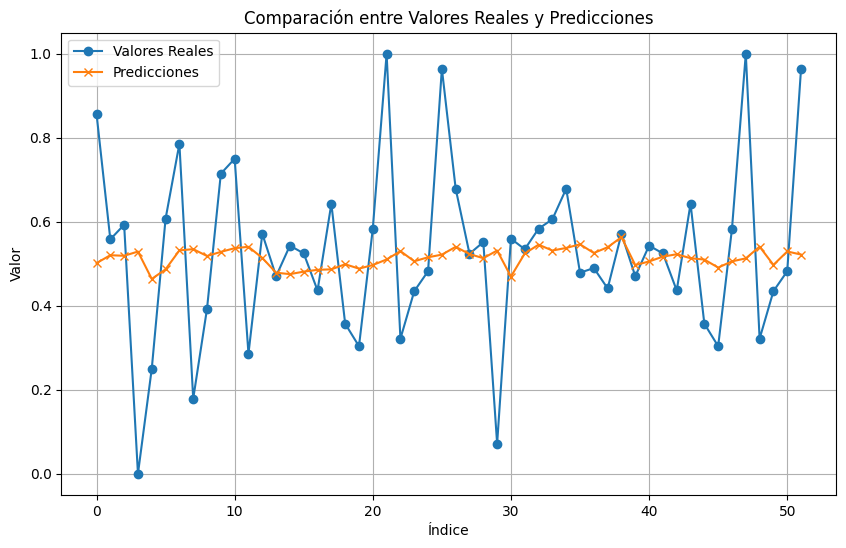

In [188]:
show_test_results(y_test_globalLSTM,y_test_global)

## Modelos LSTM Especificos

In [189]:
history_for_color = {}
for color_combination, train_gen in train_timeseries_for_color.items():
    val_gen = val_timeseries_for_color[color_combination]
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = models_for_color[color_combination].fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose=1
    )
    history_for_color[color_combination] = history

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2184 - mae: 0.4342 - val_loss: 0.0048 - val_mae: 0.0693
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 0.0157 - mae: 0.0953 - val_loss: 0.0112 - val_mae: 0.1059
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 0.0151 - mae: 0.0953 - val_loss: 0.0203 - val_mae: 0.1424
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 0.0223 - mae: 0.1158 - val_loss: 0.0160 - val_mae: 0.1265
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 0.0127 - mae: 0.0893 - val_loss: 0.0052 - val_mae: 0.0721
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 0.0195 - mae: 0.0955 - val_loss: 0.0117 - val_mae: 0.1079
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 0.0167 - mae: 0.1010 - val_loss: 0.0097 - val_mae: 0.0982
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 0.0300 - mae: 0.1344 - val_loss: 0.0045 - val_mae: 0.0667
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 0.0160 - 

### Graficos

In [190]:
training_data_summary = []

for color_combination, history in history_for_color.items():
    # Número de observaciones utilizadas para entrenar el modelo
    num_observations = len(train_timeseries_for_color[color_combination])
    
    # Obtener el MSE final del entrenamiento
    mse_values = history.history['loss']  # MSE values for training
    mae_values = history.history['mae']
    
    # Crear un resumen para la gráfica
    training_data_summary.append({
        'color_encoding': color_combination,
        'num_observations': num_observations,
        'final_mse': mse_values[-1],  # Último MSE después del entrenamiento
        'final_mae': mae_values[-1]
    })

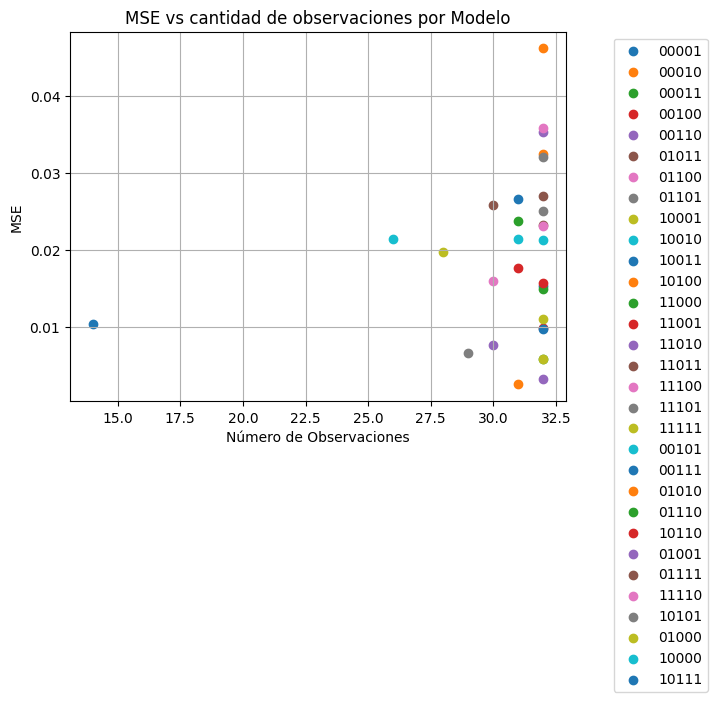

In [191]:
training_df = pd.DataFrame(training_data_summary)

for _, row in training_df.iterrows():
    plt.scatter(
        row['num_observations'],
        row['final_mse'],
        label=f"{row['color_encoding']}"
    )

# Ajustar la gráfica
plt.title("MSE vs cantidad de observaciones por Modelo")
plt.xlabel("Número de Observaciones")
plt.ylabel("MSE")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.grid(True)

# Mostrar la gráfica
plt.show()


In [192]:
from sklearn.linear_model import LinearRegression

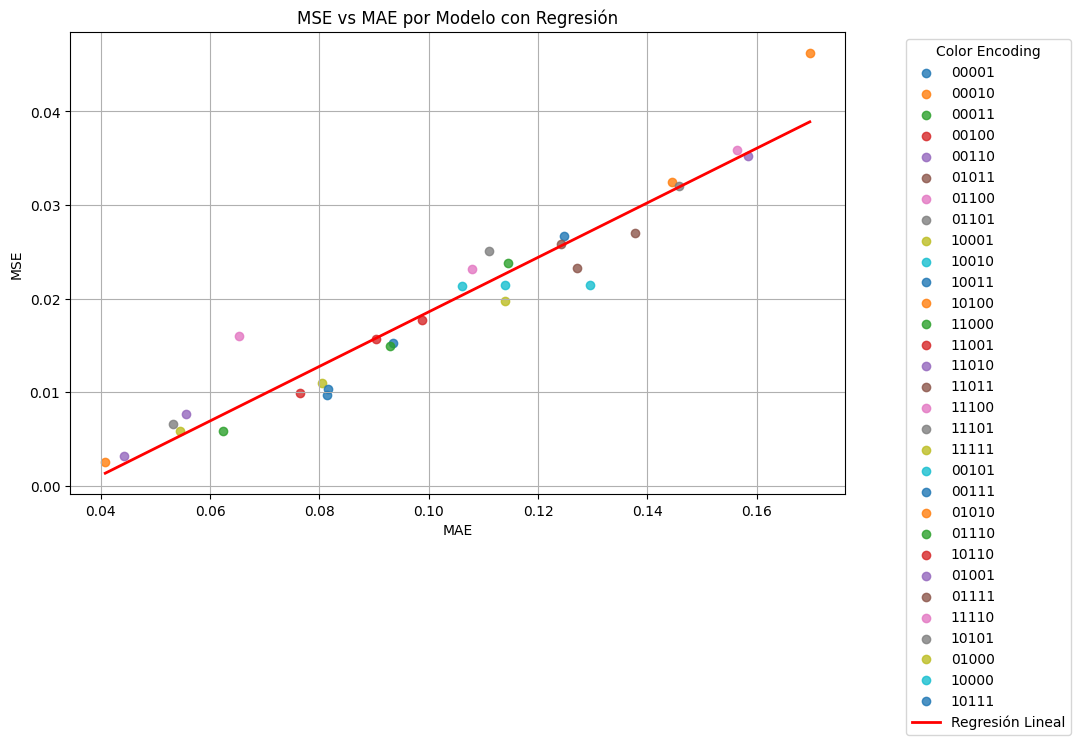

In [193]:
# Variables independientes (X: MAE) y dependientes (y: MSE)
X = training_df[['final_mae']].values  # Convertir en matriz 2D
y = training_df['final_mse'].values    # Vector 1D

# Ajustar una regresión lineal
model = LinearRegression()
model.fit(X, y)

# Predecir valores
x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)  # Generar puntos en el rango de X
y_pred = model.predict(x_range)

# Crear la gráfica
plt.figure(figsize=(10, 6))

# Trazar cada punto con su color y etiqueta
for _, row in training_df.iterrows():
    plt.scatter(
        row['final_mae'],
        row['final_mse'],
        label=f"{row['color_encoding']}",
        alpha=0.8  # Transparencia para que se note la línea de regresión
    )

# Agregar la línea de regresión
plt.plot(x_range, y_pred, label="Regresión Lineal", color='red', linewidth=2)

# Ajustar leyenda y etiquetas
plt.title("MSE vs MAE por Modelo con Regresión")
plt.xlabel("MAE")
plt.ylabel("MSE")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1), title="Color Encoding")
plt.grid(True)

# Mostrar la gráfica
plt.show()


### Prueba

In [194]:
specific_test_predictions = {}
indices_test_by_color = {}

for color_combination in monthly_df_test_complete['color_encoding'].unique():
    subset_test_data = monthly_df_test_complete[monthly_df_test_complete["color_encoding"] == color_combination]
    
    indices_test_by_color[color_combination] = subset_test_data.index
    print(len(indices_test_by_color[color_combination]))
    
    # Asegúrate de que `initial_rows` tenga los valores correctos
    initial_rows = pd.DataFrame(
        {
            "month": [0] * 6,
            "color_encoding": [color_combination] * 6,
            "average_percentile_monthly": [100] * 6,
            "average_popularity_monthly": [0] * 6,
            "average_percentile_monthly_norm": [1] * 6,
            "popularity_monthly_norm": [0] * 6,
            "color_encoding_norm": [0] * 6,
            "month_num": [0] * 6,
        }
    )

    # Aumentar los datos con el buffer inicial
    augmented_test_data = pd.concat([initial_rows, subset_test_data]).reset_index(drop=True)

    # Debugging: Imprimir tamaños después de la concatenación
    print("Test size:", len(augmented_test_data))

    # Asegúrate de usar `augmented_*` para el `TimeseriesGenerator`
    predict_test_data_gen = TimeseriesGenerator(
        augmented_test_data[specific_features].values,
        augmented_test_data[target].values,
        length=specific_sequence_length,
        batch_size=1
    )


    # Predicciones
    LSTM_test_train = np.array(models_for_color[color_combination].predict(predict_test_data_gen)).flatten()


    # Debugging: Imprimir el tamaño de las predicciones
    print("Test predictions:", len(LSTM_test_train))
    # Guardar predicciones
    specific_test_predictions[color_combination] = LSTM_test_train

2
Test size: 8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Test predictions: 2
2
Test size: 8


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Test predictions: 2
2
Test size: 8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Test predictions: 2
2
Test size: 8


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Test predictions: 2
2
Test size: 8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Test predictions: 2
2
Test size: 8


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Test predictions: 2
2
Test size: 8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Test predictions: 2
2
Test size: 8


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Test predictions: 2
2
Test size: 8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Test predictions: 2
2
Test size: 8


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Test predictions: 2
2
Test size: 8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Test predictions: 2
2
Test size: 8


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Test predictions: 2
2
Test size: 8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Test predictions: 2
2
Test size: 8


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Test predictions: 2
2
Test size: 8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Test predictions: 2
2
Test size: 8


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Test predictions: 2
2
Test size: 8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Test predictions: 2
2
Test size: 8


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Test predictions: 2
2
Test size: 8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Test predictions: 2
2
Test size: 8


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Test predictions: 2
2
Test size: 8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Test predictions: 2
2
Test size: 8


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Test predictions: 2
2
Test size: 8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Test predictions: 2
2
Test size: 8


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Test predictions: 2
2
Test size: 8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Test predictions: 2
2
Test size: 8


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Test predictions: 2


In [195]:
# Crear copias de los DataFrames originales para trabajar
test_data_with_preds = monthly_df_test_complete.copy()


# Agregar columnas para las predicciones específicas
test_data_with_preds["specificLSTM_pred_test"] = np.nan

# Asignar predicciones específicas a las filas correspondientes
for color_combination, test_indices in indices_test_by_color.items():
    train_predictions = specific_test_predictions[color_combination]
    
    # Asegurar que los índices coincidan con las predicciones
    test_data_with_preds.loc[test_indices, "specificLSTM_pred_test"] = train_predictions


In [212]:
final_test_predictions = pd.DataFrame({
    "month": test_data_with_preds["month"],
    "color_encoding": test_data_with_preds["color_encoding"],
    "specificLSTM_pred": test_data_with_preds["specificLSTM_pred_test"],
    "globalLSTM_pred": np.array(y_test_globalLSTM.flatten()),
    "denso_pred" : np.array(y_pred_dense.flatten()),
    "target": test_data_with_preds[target]
})


Mean Squared Error (MSE): 0.0365
Mean Absolute Error (MAE): 0.1566


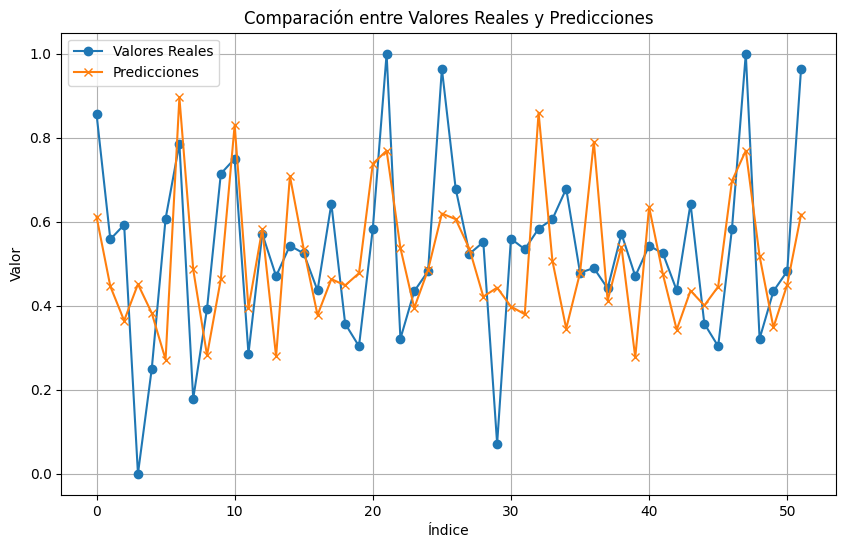

In [213]:
show_test_results(test_data_with_preds["specificLSTM_pred_test"],test_data_with_preds[target])

# Unificacion de datos

## Resultados para Capa Densa

In [198]:
denso_pred_train = np.array(modelDense.predict(X_train)).flatten()
denso_pred_val = np.array(modelDense.predict(X_val)).flatten()

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


## Resultados para LSTM Global

In [199]:
augmented_train_data = train_data.reset_index(drop=True).copy()
augmented_val_data = val_data.reset_index(drop=True).copy()

new_row = pd.DataFrame(
    {
        'month':[0], 'color_encoding':[00000], 'average_percentile_monthly':[100],
       'average_popularity_monthly':[0], 'average_percentile_monthly_norm':[1],
       'popularity_monthly_norm':[0], 'color_encoding_norm':[0], 'month_num':[0]
    }
)

augmented_train_data = pd.concat([new_row,augmented_train_data]).reset_index(drop=True)
augmented_val_data = pd.concat([new_row,augmented_val_data]).reset_index(drop=True)

full_train_gen = TimeseriesGenerator(
    augmented_train_data[global_features].values, augmented_train_data[target].values,
    length=global_sequence_length, batch_size=1
)

full_val_gen = TimeseriesGenerator(
    augmented_val_data[global_features].values, augmented_val_data[target].values,
    length=global_sequence_length, batch_size=1
)

In [200]:
globalLSTM_pred_train = np.array(modelGlobalLSTM.predict(full_train_gen)).flatten()
globalLSTM_pred_val = np.array(modelGlobalLSTM.predict(full_val_gen)).flatten()

 125/1136 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1136/1136 ━━━━━━━━━━━━━━━━━━━━ 1s 947us/step
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step


## Resultados para LSTM especificos

In [201]:
specific_predictions = {}
indices_by_color = {}

In [202]:
len(train_data[train_data["color_encoding"] == "00010"])

38

In [203]:
len(monthly_df_complete[monthly_df_complete["color_encoding"] == "00010"])

46

In [204]:
for color_combination in monthly_df_complete['color_encoding'].unique():
    subset_train_data = train_data[train_data["color_encoding"] == color_combination]
    subset_val_data = val_data[val_data["color_encoding"] == color_combination]
    
    indices_by_color[color_combination] = [subset_train_data.index, subset_val_data.index]
    print(len(indices_by_color[color_combination][0]), len(indices_by_color[color_combination][1]))
    
    # Asegúrate de que `initial_rows` tenga los valores correctos
    initial_rows = pd.DataFrame(
        {
            "month": [0] * 6,
            "color_encoding": [color_combination] * 6,
            "average_percentile_monthly": [100] * 6,
            "average_popularity_monthly": [0] * 6,
            "average_percentile_monthly_norm": [1] * 6,
            "popularity_monthly_norm": [0] * 6,
            "color_encoding_norm": [0] * 6,
            "month_num": [0] * 6,
        }
    )

    # Aumentar los datos con el buffer inicial
    augmented_train_data = pd.concat([initial_rows, subset_train_data]).reset_index(drop=True)
    augmented_val_data = pd.concat([initial_rows, subset_val_data]).reset_index(drop=True)

    # Debugging: Imprimir tamaños después de la concatenación
    print("Train size:", len(augmented_train_data))
    print("Validation size:", len(augmented_val_data))

    # Asegúrate de usar `augmented_*` para el `TimeseriesGenerator`
    predict_train_data_gen = TimeseriesGenerator(
        augmented_train_data[specific_features].values,
        augmented_train_data[target].values,
        length=specific_sequence_length,
        batch_size=1
    )
    predict_val_data_gen = TimeseriesGenerator(
        augmented_val_data[specific_features].values,
        augmented_val_data[target].values,
        length=specific_sequence_length,
        batch_size=1
    )

    # Predicciones
    LSTM_pred_train = np.array(models_for_color[color_combination].predict(predict_train_data_gen)).flatten()
    LSTM_pred_val = np.array(models_for_color[color_combination].predict(predict_val_data_gen)).flatten()

    # Debugging: Imprimir el tamaño de las predicciones
    print("Train predictions:", len(LSTM_pred_train))
    print("Validation predictions:", len(LSTM_pred_val))

    # Guardar predicciones
    specific_predictions[color_combination] = [LSTM_pred_train, LSTM_pred_val]


38

 8
Train size: 44
Validation size: 14
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train predictions: 38
Validation predictions: 8
38 8
Train size: 44
Validation size: 14


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train predictions: 38
Validation predictions: 8
38 8
Train size: 44
Validation size: 14
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train predictions: 38
Validation predictions: 8
38 8
Train size: 44
Validation size: 14


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train predictions: 38
Validation predictions: 8
38 8
Train size: 44
Validation size: 14
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train predictions: 38
Validation predictions: 8
38 8
Train size: 44
Validation size: 14


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train predictions: 38
Validation predictions: 8
38 8
Train size: 44
Validation size: 14
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train predictions: 38
Validation predictions: 8
38 8
Train size: 44
Validation size: 14


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train predictions: 38
Validation predictions: 8
38 8
Train size: 44
Validation size: 14
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train predictions: 38
Validation predictions: 8
38 8
Train size: 44
Validation size: 14


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train predictions: 38
Validation predictions: 8
38 8
Train size: 44
Validation size: 14
 1/38 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train predictions: 38
Validation predictions: 8
38 8
Train size: 44
Validation size: 14
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train predictions: 38
Validation predictions: 8
38 8
Train size: 44
Validation size: 14


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train predictions: 38
Validation predictions: 8
38 8
Train size: 44
Validation size: 14
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train predictions: 38
Validation predictions: 8
38 8
Train size: 44
Validation size: 14
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
Train predictions: 38
Validation predictions: 8
38 8
Train size: 44
Validation size: 14
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train predictions: 38
Validation predictions: 8
38 8
Train size: 44
Validation size: 14
 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
Train predictions: 38
Validation predictions: 8
38 8
Train size: 44
Validation size: 14
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
Train predictions: 38
Validation predictions: 8
38 8
Train size: 44
Validation size: 14
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train predictions: 38
Validation predictions: 8
37 8
Train size: 43
Validation size: 14
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
Train predictions: 37
Validation predictions: 8
37 8
Train size: 43
Validation size: 14
 1/37 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
Train predictions: 37
Validation predictions: 8
37 8
Train size: 43
Validation size: 14
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
Train predictions: 37
Validation predictions: 8
37 8
Train size: 43
Validation size: 14
 1/37 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train predictions: 37
Validation predictions: 8
37 8
Train size: 43
Validation size: 14
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train predictions: 37
Validation predictions: 8
36 8
Train size: 42
Validation size: 14


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train predictions: 36
Validation predictions: 8
36 8
Train size: 42
Validation size: 14
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train predictions: 36
Validation predictions: 8
36 8
Train size: 42
Validation size: 14


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train predictions: 36
Validation predictions: 8
35 8
Train size: 41
Validation size: 14
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train predictions: 35
Validation predictions: 8
34 8
Train size: 40
Validation size: 14


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train predictions: 34
Validation predictions: 8
32 8
Train size: 38
Validation size: 14
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train predictions: 32
Validation predictions: 8
20 8
Train size: 26
Validation size: 14


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train predictions: 20
Validation predictions: 8


In [205]:
# Crear copias de los DataFrames originales para trabajar
train_data_with_preds = train_data.copy()
val_data_with_preds = val_data.copy()

# Agregar columnas para las predicciones específicas
train_data_with_preds["specificLSTM_pred_train"] = np.nan
val_data_with_preds["specificLSTM_pred_val"] = np.nan

# Asignar predicciones específicas a las filas correspondientes
for color_combination, (train_indices, val_indices) in indices_by_color.items():
    train_predictions = specific_predictions[color_combination][0]
    val_predictions = specific_predictions[color_combination][1]
    
    # Asegurar que los índices coincidan con las predicciones
    train_data_with_preds.loc[train_indices, "specificLSTM_pred_train"] = train_predictions
    val_data_with_preds.loc[val_indices, "specificLSTM_pred_val"] = val_predictions



## Union de resultados

In [206]:
train_data_with_preds.head()

,month,color_encoding,average_percentile_monthly,average_popularity_monthly,average_percentile_monthly_norm,popularity_monthly_norm,color_encoding_norm,month_num,specificLSTM_pred_train
0,2021-01,00001,47.694672,6.1,0.460074,1.960095,0.032258,1,0.582675
1,2021-01,00010,32.756696,3.5,0.305876,1.504077,0.064516,1,0.279129
2,2021-01,00011,43.750000,1.5,0.419355,0.916291,0.096774,1,0.708714
3,2021-01,00100,40.487939,3.8,0.385682,1.568616,0.129032,1,0.612281
4,2021-01,00110,59.375000,1.0,0.580645,0.693147,0.193548,1,0.446211


In [207]:

final_train_predictions = pd.DataFrame({
    "month": train_data_with_preds["month"],
    "color_encoding": train_data_with_preds["color_encoding"],
    "specificLSTM_pred": train_data_with_preds["specificLSTM_pred_train"],
    "globalLSTM_pred": globalLSTM_pred_train,
    "denso_pred" : denso_pred_train,
    "target": train_data_with_preds[target]
})

final_val_predictions = pd.DataFrame({
    "month": val_data_with_preds["month"],
    "color_encoding": val_data_with_preds["color_encoding"],
    "specificLSTM_pred": val_data_with_preds["specificLSTM_pred_val"],
    "globalLSTM_pred": globalLSTM_pred_val,
    "denso_pred" : denso_pred_val,
     "target" : val_data_with_preds[target]
})

print(final_train_predictions.head())
print(final_val_predictions.head())

     month color_encoding  specificLSTM_pred  globalLSTM_pred  denso_pred  \
0  2021-01          00001           0.582675         0.501456    0.437637   
1  2021-01          00010           0.279129         0.499195    0.389060   
2  2021-01          00011           0.708714         0.486453    0.431399   
3  2021-01          00100           0.612281         0.496092    0.396516   
4  2021-01          00110           0.446211         0.501323    0.457379   

     target  
0  0.460074  
1  0.305876  
2  0.419355  
3  0.385682  
4  0.580645  
        month color_encoding  specificLSTM_pred  globalLSTM_pred  denso_pred  \
1136  2024-03          00001           0.582675         0.501456    0.459292   
1137  2024-03          00010           0.279129         0.499792    0.492104   
1138  2024-03          00011           0.708714         0.470616    0.477236   
1139  2024-03          00100           0.612281         0.506420    0.347408   
1140  2024-03          00110           0.446211      

## Segundo Entrenamiento
Modelos que votan

#### Votacion por mayoria

In [208]:
final_test_predictions.head()

,month,color_encoding,specificLSTM_pred,denso_pred,target
0,2024-10,00100,0.612281,0.513911,0.857143
1,2024-10,00110,0.446211,0.413085,0.558036
2,2024-10,01010,0.364430,0.393224,0.592857
3,2024-10,01011,0.451380,0.507230,0.000000
4,2024-10,01100,0.382476,0.505213,0.250000


In [214]:
def majority_vote(row):
    predictions = [
        row["specificLSTM_pred"],
        row["globalLSTM_pred"],
        row["denso_pred"]
    ]
    return max(set(predictions), key=predictions.count)

final_train_predictions["majority_vote"] = final_train_predictions.apply(majority_vote, axis=1)

def majority_vote_val(row):
    predictions = [
        row["specificLSTM_pred"],
        row["globalLSTM_pred"],
        row["denso_pred"]
    ]
    return max(set(predictions), key=predictions.count)

final_val_predictions["majority_vote"] = final_val_predictions.apply(majority_vote_val, axis=1)

final_test_predictions["majority_vote"] = final_test_predictions.apply(majority_vote_val, axis=1)


### Votacion por pesos

In [215]:
weights = {
    "specificLSTM": 0.3,
    "globalLSTM": 0.5,
    "denso": 0.2
}

final_train_predictions["weighted_vote"] = (
    weights["specificLSTM"] * final_train_predictions["specificLSTM_pred"] +
    weights["globalLSTM"] * final_train_predictions["globalLSTM_pred"] +
    weights["denso"] * final_train_predictions["denso_pred"]
)

final_val_predictions["weighted_vote"] = (
    weights["specificLSTM"] * final_val_predictions["specificLSTM_pred"] +
    weights["globalLSTM"] * final_val_predictions["globalLSTM_pred"] +
    weights["denso"] * final_val_predictions["denso_pred"]
)

final_test_predictions["weighted_vote"] = (
    weights["specificLSTM"] * final_test_predictions["specificLSTM_pred"] +
    weights["globalLSTM"] * final_test_predictions["globalLSTM_pred"] +
    weights["denso"] * final_test_predictions["denso_pred"]
)


### Votacion por random forest

In [216]:
from sklearn.ensemble import RandomForestRegressor

# Entrenamiento
X_train_vote = final_train_predictions[["specificLSTM_pred", "globalLSTM_pred", "denso_pred"]]
y_train_vote = train_data_with_preds[target]  # Reemplaza con la columna objetivo real
meta_model = RandomForestRegressor()
meta_model.fit(X_train_vote, y_train_vote)

# Predicción
X_val_vote = final_val_predictions[["specificLSTM_pred", "globalLSTM_pred", "denso_pred"]]
final_val_predictions["random_forest_vote"] = meta_model.predict(X_val_vote)
final_train_predictions["random_forest_vote"] = meta_model.predict(X_train_vote)

X_test_vote = final_test_predictions[["specificLSTM_pred", "globalLSTM_pred", "denso_pred"]]
final_test_predictions["random_forest_vote"] = meta_model.predict(X_test_vote)



In [217]:
final_train_predictions.head()


,month,color_encoding,specificLSTM_pred,globalLSTM_pred,denso_pred,target,majority_vote,weighted_vote,random_forest_vote
0,2021-01,00001,0.582675,0.501456,0.437637,0.460074,0.582675,0.513058,0.491095
1,2021-01,00010,0.279129,0.499195,0.389060,0.305876,0.279129,0.411148,0.425149
2,2021-01,00011,0.708714,0.486453,0.431399,0.419355,0.708714,0.542120,0.415061
3,2021-01,00100,0.612281,0.496092,0.396516,0.385682,0.612281,0.511033,0.451515
4,2021-01,00110,0.446211,0.501323,0.457379,0.580645,0.446211,0.476001,0.540741


In [218]:
final_val_predictions.head()

,month,color_encoding,specificLSTM_pred,globalLSTM_pred,denso_pred,target,majority_vote,weighted_vote,random_forest_vote
1136,2024-03,00001,0.582675,0.501456,0.459292,0.434616,0.582675,0.517389,0.495427
1137,2024-03,00010,0.279129,0.499792,0.492104,0.246260,0.279129,0.432055,0.532912
1138,2024-03,00011,0.708714,0.470616,0.477236,0.589067,0.708714,0.543370,0.398309
1139,2024-03,00100,0.612281,0.506420,0.347408,0.499467,0.612281,0.506376,0.499773
1140,2024-03,00110,0.446211,0.506886,0.295385,0.482823,0.446211,0.446384,0.468562


In [219]:
final_test_predictions.head()

,month,color_encoding,specificLSTM_pred,globalLSTM_pred,denso_pred,target,majority_vote,weighted_vote,random_forest_vote
0,2024-10,00100,0.612281,0.501456,0.513911,0.857143,0.612281,0.537194,0.674833
1,2024-10,00110,0.446211,0.520248,0.413085,0.558036,0.446211,0.476604,0.408669
2,2024-10,01010,0.364430,0.518917,0.393224,0.592857,0.364430,0.447432,0.335568
3,2024-10,01011,0.451380,0.528936,0.507230,0.000000,0.451380,0.501328,0.644902
4,2024-10,01100,0.382476,0.463773,0.505213,0.250000,0.382476,0.447672,0.482550


In [220]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [221]:
def evaluate_model(predictions, actuals, model_name):
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    print(f"{model_name} Performance:")
    print(f" - Mean Absolute Error (MAE): {mae:.4f}")
    print(f" - Root Mean Squared Error (RMSE): {rmse:.4f}")
    print("-" * 40)
    return mae, rmse

In [222]:
# Comparar rendimientos en conjunto de entrenamiento
print("Training Performance:")
train_actual = train_data_with_preds[target]  # Columna objetivo real para entrenamiento

evaluate_model(final_train_predictions["specificLSTM_pred"], train_actual, "Specific LSTM")
evaluate_model(final_train_predictions["globalLSTM_pred"], train_actual, "Global LSTM")
evaluate_model(final_train_predictions["denso_pred"], train_actual, "Denso")
evaluate_model(final_train_predictions["majority_vote"], train_actual, "Majority vote")
evaluate_model(final_train_predictions["weighted_vote"], train_actual, "Weighted vote")
evaluate_model(final_train_predictions["random_forest_vote"], train_actual, "Random Forest vote")

# Comparar rendimientos en conjunto de validación
print("\nValidation Performance:")
val_actual = val_data_with_preds[target]  # Columna objetivo real para validación

evaluate_model(final_val_predictions["specificLSTM_pred"], val_actual, "Specific LSTM")
evaluate_model(final_val_predictions["globalLSTM_pred"], val_actual, "Global LSTM")
evaluate_model(final_val_predictions["denso_pred"], val_actual, "Denso")
evaluate_model(final_val_predictions["majority_vote"], val_actual, "Majority Model")
evaluate_model(final_val_predictions["weighted_vote"], val_actual, "Weighted Model")
evaluate_model(final_val_predictions["random_forest_vote"], val_actual, "Random Forest Model")

# Comparar rendimiento en conjunto de prueba
print("\nTest Performance:")
test_actual = test_data_with_preds[target]  # Columna objetivo real para validación

evaluate_model(final_test_predictions["specificLSTM_pred"], test_actual, "Specific LSTM")
evaluate_model(final_test_predictions["globalLSTM_pred"], test_actual, "Global LSTM")
evaluate_model(final_test_predictions["denso_pred"], test_actual, "Denso")
evaluate_model(final_test_predictions["majority_vote"], test_actual, "Majority Model")
evaluate_model(final_test_predictions["weighted_vote"], test_actual, "Weighted Model")
evaluate_model(final_test_predictions["random_forest_vote"], test_actual, "Random Forest Model")

Training Performance:
Specific LSTM Performance:
 - Mean Absolute Error (MAE): 0.1298
 - Root Mean Squared Error (RMSE): 0.1778
----------------------------------------
Global LSTM Performance:
 - Mean Absolute Error (MAE): 0.1219
 - Root Mean Squared Error (RMSE): 0.1610
----------------------------------------
Denso Performance:
 - Mean Absolute Error (MAE): 0.1294
 - Root Mean Squared Error (RMSE): 0.1674
----------------------------------------
Majority vote Performance:
 - Mean Absolute Error (MAE): 0.1298
 - Root Mean Squared Error (RMSE): 0.1778
----------------------------------------
Weighted vote Performance:
 - Mean Absolute Error (MAE): 0.1197
 - Root Mean Squared Error (RMSE): 0.1603
----------------------------------------
Random Forest vote Performance:
 - Mean Absolute Error (MAE): 0.0437
 - Root Mean Squared Error (RMSE): 0.0603
----------------------------------------

Validation Performance:
Specific LSTM Performance:
 - Mean Absolute Error (MAE): 0.1186
 - Root Mean

(0.1680922027137182, 0.22577919790961626)

# Prediccion

In [ ]:
# def predict(color_comb, popularity_values, max_popularity, max_position):
#     color_comb = encode_colors(color_comb)
#     color_encoding_norm = int(''.join(color_comb),2)/31
#     sequence_length = 6  

#     popularity_values_normalized = (np.array(popularity_values) - 1) / (max_popularity - 1)

#     input_sequences = []
#     for popularity in popularity_values_normalized:
#         sequence = [[color_encoding_norm, 0, popularity]] * sequence_length
#         input_sequences.append(sequence)

#     input_sequences = np.array(input_sequences)
    
#     predictions = model.predict(input_sequences)

#     predictions_denormalized = predictions * (max_position - 1) + 1
    
#     for pop, pred in zip(popularity_values, predictions_denormalized):
#         print(f"Popularidad: {pop}, Predicción de posición promedio: {pred[0]:.2f}")
    
#     return predictions_denormalized

In [ ]:
# max_popularity = 20
# max_position = 20

# color_comb = ['blue', 'red']
# popularity_values = [1,5,10,15,20]

In [ ]:
# predictions_denormalized = predict(color_comb=color_comb, popularity_values=popularity_values, max_popularity=max_popularity, max_position=max_position)